## PyTorch Workflow

Let's explore an example of a PyTorch end-to-end workflow.

Resources:
* Ground truth notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
* Book version of notebook - https://www.learnpytorch.io/01_pytorch_workflow/

In [1]:
what_were_covering={1: "data(prepare and load)",
                    2: "build model",
                    3: "fitting the model to the data (training)",
                    4: "making predictions and evaluating a model (inference))",
                    5: "saving and loading the model",
                    6: "putting it all together"}
what_were_covering

{1: 'data(prepare and load)',
 2: 'build model',
 3: 'fitting the model to the data (training)',
 4: 'making predictions and evaluating a model (inference))',
 5: 'saving and loading the model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn #nn contains all of pytorch's building block for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.3.0+cu121'

## 1. Data Preparing and loading

Data can be almost anything in ML:
* Excels preadsheets
* Images of any kind
* Videos
* Audio like songs
* Text

ML is two parts:
1. Get data into numerical representation
2. Build Model to learn patterns in numerical representation.

Let's create some known data using the linear regression formula.

We'll use the linear reg formula to make a straight line with known **parameters**.

In [64]:
#Create known parameters
weight=0.7
bias=0.3
# create
start=0
end=1
step=0.02
X=torch.arange(start,end,step).unsqueeze(dim=1)
y=weight*X+bias

X[:10], y[:10]
len(X), len(y)

(50, 50)

### Splitting data into training and test datasets (important)

create training and test set

In [65]:
#Create train/tst split
train_split=int(0.8*len(X))
#test_split=int(0.2*len(X))

X_train, y_train=X[:train_split], y[:train_split]
X_test, y_test=X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might be better visualize our data? - Always visualize the data

In [66]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10,7))
#plot training data in red
  plt.scatter(train_data,train_labels,c='r',s=4,label="Training dataset")
  #Plot testing data in green
  plt.scatter(test_data, test_labels,c="#182D09",s=4,label="Testing data")

  #Are there predicitions?
  if predictions is not None:
    plt.scatter(test_data, predictions,c="purple",s=4,label="prediction")

  #show legend

  plt.legend();

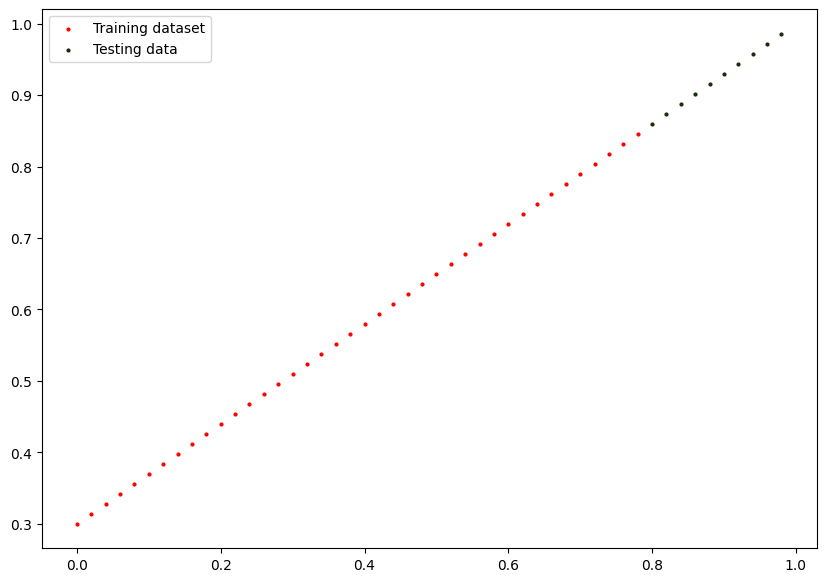

In [67]:
plot_predictions();

## 2. Build model

1st PyTorch model

Classes documentation: https://realpython.com/python3-object-oriented-programming/

what our mode does:
* Start with random values (weights and bias)
* Lok at training data and adjust random values to better represent ideal values (weights and bias used to create the data)

How does it do this?

Through 2 algorithms:
1. Gradient descent
2. Backpropagation

In [79]:
from torch import nn
#Create Linear regression model class
class LinearRegressionModel(nn.Module): #<- almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights=nn.Parameter(torch.randn(1, # <-start with a random weight and try to adjust to ideal weight
                                          requires_grad=True, #<-be upgraded via gradient descent
                                           dtype=torch.float)) #<-PyTorch loves torch.float32

    self.bias=nn.Parameter(torch.randn(1,
                                       requires_grad=True,
                                       dtype=torch.float))

    #forward method to define the computation in the model
  def forward(self, x: torch.Tensor)-> torch.Tensor: #"x" is the input data
    return self.weights*x+self.bias #linear regression formula


### PyTorch model building essentials

* torch.nn - contains all building blocks for computational graphs (a nueral ntwrok can be considered a computation graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn with set these for us
*torch.nn.Module-The base class for all nueral network modules, if you subclass, you should overwrite forward()
*torch.optim- this is where the optimizers in PyTorch Live, help with gradient descent
*def forward()-All nn.Module sublasses require you to overwrite forward(), this method defines what happens in the forward computation

see more of these essentials- https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the contents of PyTorch model

Lets see what's inside

check out model parameters using `.parameters`

In [80]:
#create random seed
torch.manual_seed(77)

#create instance of the model (this is a sublass of nn.Module)

model_0=LinearRegressionModel()
#check out parameters (parameter is a value model sets itelf)
list(model_0.parameters())

#List named parameters
model_0.state_dict()

print(f"parameters: \n{list(model_0.parameters())}")
print(f"\ndictionary of parameters: \n{model_0.state_dict()}")

parameters: 
[Parameter containing:
tensor([-0.3568], requires_grad=True), Parameter containing:
tensor([0.6007], requires_grad=True)]

dictionary of parameters: 
OrderedDict([('weights', tensor([-0.3568])), ('bias', tensor([0.6007]))])


### Making predictions using `torch.inference_mode()`

to check model predictive power, let's see how well it predicts `y_test` based on `x_test`

When we pass data through the model, run through the forward() method

In [81]:
#'Make predictions with model'
with torch.inference_mode():
  y_preds=model_0(X_test)

y_preds, y_test

(tensor([[0.3153],
         [0.3081],
         [0.3010],
         [0.2938],
         [0.2867],
         [0.2796],
         [0.2724],
         [0.2653],
         [0.2582],
         [0.2510]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

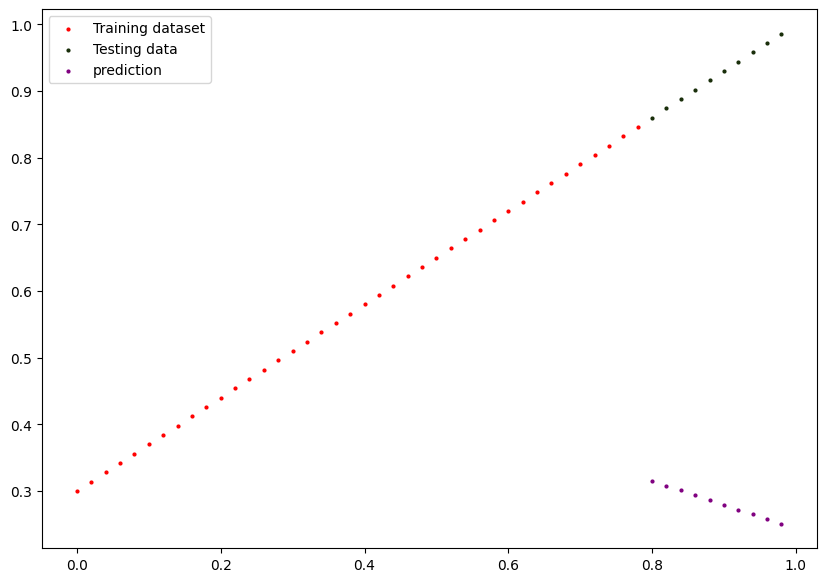

In [82]:
plot_predictions(predictions=y_preds)

## 3. Train Model

The whole idea of training is moving a model from *unknown* parameters to *known* parameters

Or go from a poor representation to a better representation of the data

One way to measure how poor/wrong a model is to use a loss function

* Note: Loss function may also be called cost function or criterion in different areas.

Things we need to change

* **Loss Function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower=better

* **Optimizer:** Takes into account loss of a model and adjusts the model's parameters (e.g weights,bias) to improve the loss function

 * Inisde the optimizer two parameters are often set:
  * `params` - model parameters you'd like to optimize, e.g `params=model_0.parameters`
  * `lr`(learning rate-a small `lr` results in small change and a large in large changes)

And specifically for PyTorch we need:
* Training loop
* Testing loop



In [83]:
# Setup loss function
loss_fn=nn.L1Loss()

#Setup an optimizer (stochastic gradient descent)
optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.01)# lr=learning rate=most important hyperparameter you can set

loss_fn, optimizer

(L1Loss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

*Q* which loss function should I use?
*A* This will be problem specific but with experience you'll get an idea of what works what what doesn't

For example for a regression a function `nn.L1Loss()` and optimizer like `torch.optim.SGD` will suffice

But for classifiocation problems (like photos of cats and dogs) you'll likely use `nn.BCELoss() (binary cross entropy loss)

### Building a training (and testing) loop in PyTorch

A couple things we need in traiing loop:
0. Loop through the data
1. forward pass(this involves data moving through model's `forward()` functions) to make predictions-also called a forward propogation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backwards - move backwards through the betwork to calculate gradients of each parameters of our model with repsect to loss (**backpropogation**)
5. Optimizer step - use optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [84]:
#An epoch is 1 loop through the data...(this is a hyperparameter)
epochs=1000

#tracking different values
epoch_count=[]
loss_value=[]
test_loss_value=[]

##Training
#0. Loop through the data
for epoch in range(epochs):
  #set model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  #1. Forward pass
  y_pred=model_0(X_train)

  #2. Calculate the loss
  loss=loss_fn(y_pred,y_train)
  #print(f"Loss: {loss}")

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Perform backpropogation on the loss with respect to the parameters of the model
  loss.backward()

  #5.Step the optimizer (perform gradient descent)
  optimizer.step() # by default how optimzer changes will accumulate through the loop so.. we have to zero them above in step 3

###Testing
  model_0.eval() # turns off gradient tracking and different settings in model not needed for evaluation/testing (dropout/ batch layers)
  with torch.inference_mode(): #turns off gradient tracking and a couple more things behind the scenes can also be with torch.no_grad()
  #1. Do forward pass still
    test_pred=model_0(X_test)

  #2. calculate the loss
    test_loss=loss_fn(test_pred,y_test)

  if epoch%100==0:
    epoch_count.append(epoch)
    loss_value.append(loss)
    test_loss_value.append(test_loss)
    print(f"Epoch {epoch} | Loss: {loss} | Test loss: {test_loss}")

#print out model state_dict()
    print(model_0.state_dict())

Epoch 0 | Loss: 0.2260170727968216 | Test loss: 0.634822428226471
OrderedDict([('weights', tensor([-0.3540])), ('bias', tensor([0.6032]))])
Epoch 100 | Loss: 0.16877111792564392 | Test loss: 0.40467461943626404
OrderedDict([('weights', tensor([-0.1403])), ('bias', tensor([0.6432]))])
Epoch 200 | Loss: 0.13421662151813507 | Test loss: 0.31302228569984436
OrderedDict([('weights', tensor([0.0340])), ('bias', tensor([0.5797]))])
Epoch 300 | Loss: 0.09986960142850876 | Test loss: 0.23304660618305206
OrderedDict([('weights', tensor([0.2048])), ('bias', tensor([0.5077]))])
Epoch 400 | Loss: 0.06553015112876892 | Test loss: 0.15238220989704132
OrderedDict([('weights', tensor([0.3757])), ('bias', tensor([0.4362]))])
Epoch 500 | Loss: 0.031184528023004532 | Test loss: 0.07240431755781174
OrderedDict([('weights', tensor([0.5465])), ('bias', tensor([0.3642]))])
Epoch 600 | Loss: 0.003483446780592203 | Test loss: 0.007154440972954035
OrderedDict([('weights', tensor([0.6982])), ('bias', tensor([0.30

In [21]:
model_0.state_dict(), weight, bias

(OrderedDict([('weights', tensor([-0.3454])), ('bias', tensor([0.6107]))]),
 0.7,
 0.3)

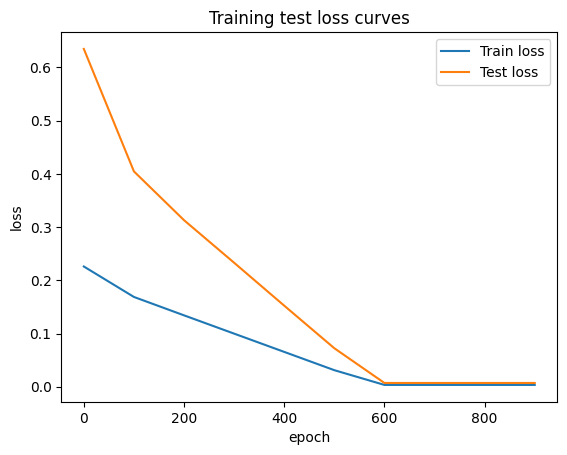

In [88]:
#plot loss curves
import numpy as np
#convert tensor to numpy
#.cpu() for when on gpu()
lsvl=np.array(torch.tensor(loss_value).numpy())
Tlsvl=np.array(torch.tensor(test_loss_value).numpy())
plt.plot(epoch_count, lsvl, label="Train loss")
plt.plot(epoch_count, test_loss_value, label="Test loss")
plt.title("Training test loss curves")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()

In [77]:
with torch.inference_mode():
  y_preds_new5=model_0(X_test)

# y_preds_new2 after 100 epochs
# y_preds_new3 after 10000 epochs (could probably be less)
# y_preds_new4 after 100  epochs with test loop
# y_preds_new5 after 1000 epochs with test loop Epoch 900 | Loss: 0.003483446780592203 | Test loss: 0.007154440972954035
#OrderedDict([('weights', tensor([0.6982])), ('bias', tensor([0.3087]))])

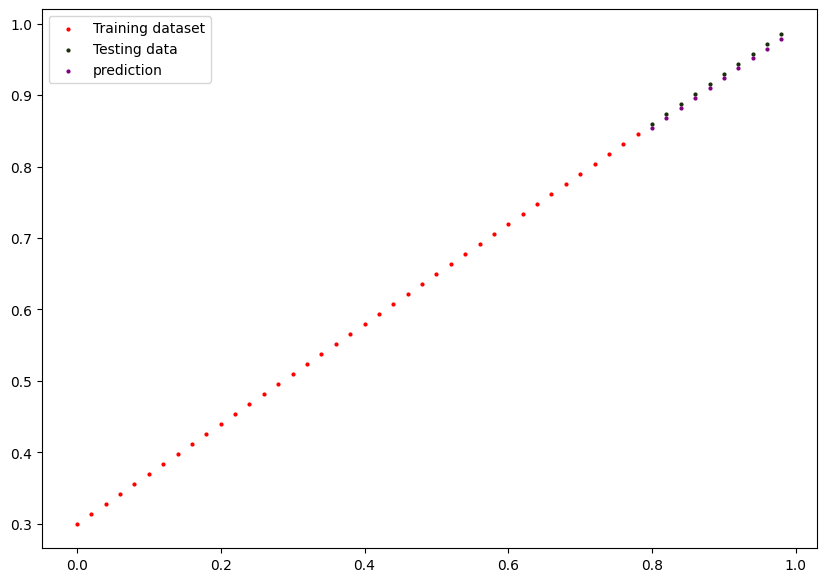

In [78]:
plot_predictions(predictions=y_preds_new5)

### Saving a model in PyTorch

There are three main methods for saving a loading a model in PyTorch

1. `torch.save()` - allows you to save an PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

Pytorch save and load tutorial - https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [91]:
# Saving out PyTorch model

from pathlib import Path

#1. create model directory
MODEL_PATH=Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Model Save Path

MODEL_NAME="01_PyTorch_Linear_regression_Workflow_model_0.pth"
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME



#3. Save the model state_dict()
print(f"saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),f=MODEL_SAVE_PATH)

saving model to models/01_PyTorch_Linear_regression_Workflow_model_0.pth


In [92]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1852 Jun 12 12:25 01_PyTorch_Linear_regression_Workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict` into that

In [93]:
#load in a save state_dict we have to instantiate a new instance of model class
loaded_model_0=LinearRegressionModel()
print(f"loaded_model stats: {loaded_model_0.state_dict()}")
#Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
print(f"After loading loaded_model stats: {loaded_model_0.state_dict()}")

loaded_model stats: OrderedDict([('weights', tensor([-0.6968])), ('bias', tensor([-0.5242]))])
After loading loaded_model stats: OrderedDict([('weights', tensor([0.6943])), ('bias', tensor([0.2987]))])


In [94]:
# Make some predictions with loaded model

loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds=loaded_model_0(X_test)

loaded_model_preds

#compare loaded with original

y_preds_new5==loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

##6. Putting it all together

Let's go through above steps and see it all in 1 place

In [95]:
#import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

##Check PyTorch version
torch.__version__

'2.3.0+cu121'

Create DEvice agnostic code.

This means if we've got access to a GPU our code will use it but if not available will default to CPU

In [96]:
#Setop device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


###6.1 Data

In [97]:
#Lets' create some data using weights, biases, y=weight*X+bias

weight=0.5
bias=0.5

#create range
start=0
end=1
step=0.02

#create X and y
X=torch.arange(start,end,step).unsqueeze(dim=1)#without unsqueeze error will pop up
y=weight*X+bias
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.5000],
         [0.5100],
         [0.5200],
         [0.5300],
         [0.5400],
         [0.5500],
         [0.5600],
         [0.5700],
         [0.5800],
         [0.5900]]))

In [99]:
#Split date
train_split=int(0.8*len(X))
X_train, y_train=X[:train_split], y[:train_split]
X_test, y_test=X[train_split:], y[train_split:]
len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

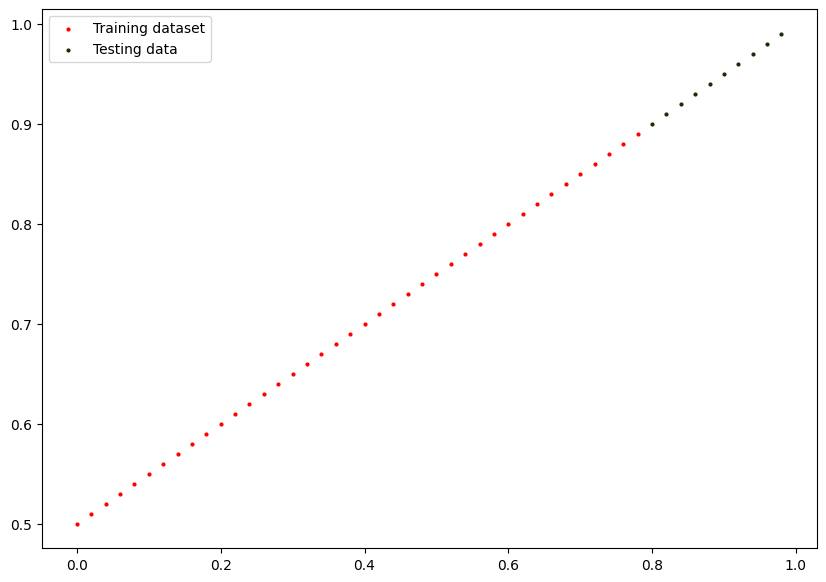

In [100]:
#plot Data using plot predictions above
plot_predictions(X_train,y_train,X_test,y_test)

### 6.2 building a PyTorch Linear model

In [102]:
#Creat a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() instead of nn.Parameter() for creating the model parameters/also called linear transform, probing layer
    self.linear_layer=nn.Linear(in_features=1, #
                                out_features=1) #

  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

#set the manual seed
torch.manual_seed(42)
model_1=LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [106]:
# set the model to use target device
next(model_1.parameters()).device
#if cuda next line would come out as cuda or cpu respectively
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

###6.3 Training Code

for traiing we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [107]:
#Setip Loss function
loss_fn=nn.L1Loss()# same as Mean absolute Error MAE

#Optimizer
optimizer=torch.optim.SGD(params=model_1.parameters(),
                          lr=0.01)

#Let's write training loop
torch.manual_seed(42)

epochs=200

#put data on traget device to prevent errors in difference of model and data device location
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
X_test=y_test.to(device)

#tracking different values
epoch_count=[]
loss_value=[]
test_loss_value=[]

for epoch in range(epochs):
  model_1.train()

  #1. Forward pass
  y_pred=model_1(X_train)

  #2. Calculate the loss
  loss=loss_fn(y_pred,y_train)

  #3. Optimizer zero graaad
  optimizer.zero_grad()

  #4. LOOOSSSS BACKWARDs (backpropogation)
  loss.backward()

  #5.Optimizer step
  optimizer.step()


  ###Testing###
  model_1.eval() #see above
  with torch.inference_mode():
    test_pred=model_1(X_test)
    test_loss=loss_fn(test_pred,y_test)

  if epoch%20==0:
    epoch_count.append(epoch)
    loss_value.append(loss)
    test_loss_value.append(test_loss)
    print(f"Epoch {epoch} | Loss: {loss} | Test loss: {test_loss}")



Epoch 0 | Loss: 0.4331779479980469 | Test loss: 0.5938113331794739
Epoch 20 | Loss: 0.20275822281837463 | Test loss: 0.32010164856910706
Epoch 40 | Loss: 0.022884894162416458 | Test loss: 0.09217360615730286
Epoch 60 | Loss: 0.01503742951899767 | Test loss: 0.066162109375
Epoch 80 | Loss: 0.008168170228600502 | Test loss: 0.047729410231113434
Epoch 100 | Loss: 0.0013097136979922652 | Test loss: 0.02930617891252041
Epoch 120 | Loss: 0.0032349228858947754 | Test loss: 0.02010110579431057
Epoch 140 | Loss: 0.0032349228858947754 | Test loss: 0.02010110579431057
Epoch 160 | Loss: 0.0032349228858947754 | Test loss: 0.02010110579431057
Epoch 180 | Loss: 0.0032349228858947754 | Test loss: 0.02010110579431057


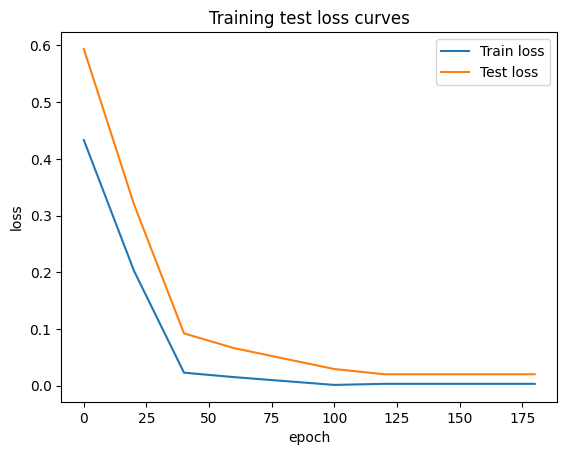

In [108]:
#plot loss curves
import numpy as np
#convert tensor to numpy
#.cpu() for when on gpu()
lsvl=np.array(torch.tensor(loss_value).numpy())
Tlsvl=np.array(torch.tensor(test_loss_value).numpy())
plt.plot(epoch_count, lsvl, label="Train loss")
plt.plot(epoch_count, test_loss_value, label="Test loss")
plt.title("Training test loss curves")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()

In [109]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5044]])),
             ('linear_layer.bias', tensor([0.5015]))])

###6.4 Making and evaulating predictions

In [111]:
#Turn model into evaluation mode
model_1.eval()

#Make predictions with test data
with torch.inference_mode():
  y_preds=model_1(X_test)

y_preds

tensor([[0.9555],
        [0.9605],
        [0.9656],
        [0.9706],
        [0.9757],
        [0.9807],
        [0.9858],
        [0.9908],
        [0.9958],
        [1.0009]])

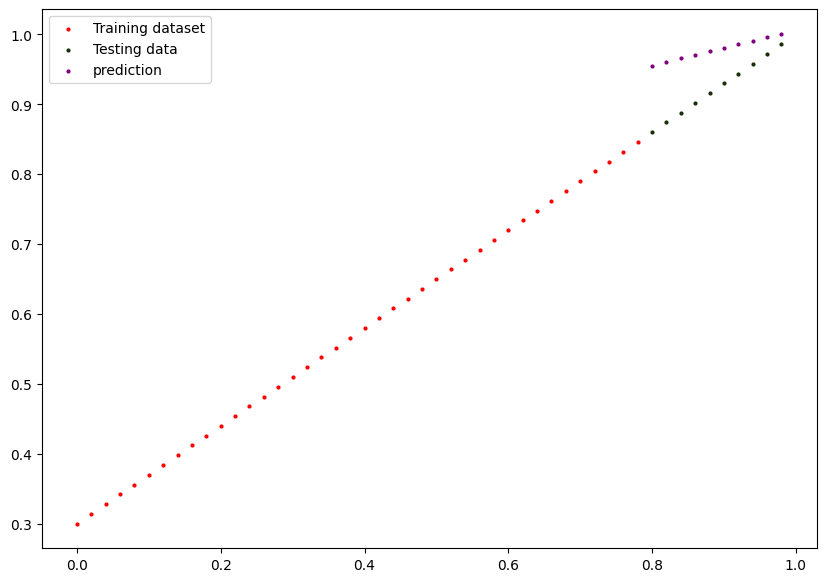

In [113]:
plot_predictions(predictions=y_preds)

###6.5 Saving and loading a trained model

In [116]:
# Saving out PyTorch model

from pathlib import Path

#1. create model directory
MODEL_PATH=Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Model Save Path

MODEL_NAME="01_PyTorch_Linear_regression_Workflow_model_1.pth"
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME



#3. Save the model state_dict()
print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)

saving model to: models/01_PyTorch_Linear_regression_Workflow_model_1.pth


In [118]:
# Load a PyTorch model
#create new instance of LRM V2
loaded_model_1=LinearRegressionModelV2()
print(f"loaded_model stats: {loaded_model_1.state_dict()}")

#load model state dict
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
print(f"After loading loaded_model stats: {loaded_model_1.state_dict()}")

#Put model to device
loaded_model_1.to(device)

loaded_model stats: OrderedDict([('linear_layer.weight', tensor([[-0.2191]])), ('linear_layer.bias', tensor([0.2018]))])
After loading loaded_model stats: OrderedDict([('linear_layer.weight', tensor([[0.5044]])), ('linear_layer.bias', tensor([0.5015]))])


LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [120]:
# Evaluate loaded model

loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds=loaded_model_1(X_test)

loaded_model_1_preds

#compare loaded with original

y_preds==loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Exercises & Extra-curriculum

Refer to: https://www.learnpytorch.io/01_pytorch_workflow/